In [1]:
from ANEMO import ANEMO
from ANEMO.edfreader import read_edf
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import lmfit
from lmfit import  Model, Parameters

In [2]:
def new_vitesse(x, dir_target, start_anti, a_anti, latency, maxi, ramp_pursuit, do_whitening) :

    a_anti = a_anti/1000 # to switch from sec to ms
    ramp_pursuit = dir_target*(ramp_pursuit)/1000
    time = x
    vitesse = []
    y = 0
    end_ramp_pursuit = ((dir_target*maxi)/ramp_pursuit) + latency
    
    for t in range(len(time)):
        
        if start_anti >= latency :
            
            if time[t] < latency :
                vitesse.append(0)
            else :
                if latency >= end_ramp_pursuit :
                    vitesse.append(dir_target*maxi)
                else :
                    if time[t] < end_ramp_pursuit : vitesse.append((time[t]-latency)*ramp_pursuit)
                    else :                vitesse.append(dir_target*maxi)
        
        #-------------------------------------------------------------------------------
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latency :
                    vitesse.append((time[t]-start_anti)*a_anti)
                    y = (time[t]-start_anti)*a_anti
                else :
                    if latency >= end_ramp_pursuit :
                        vitesse.append(dir_target*maxi)
                    else :
                        if time[t] < int(end_ramp_pursuit) : vitesse.append((time[t]-latency)*ramp_pursuit+y)
                        else :                vitesse.append(dir_target*maxi+y)
        

    return vitesse

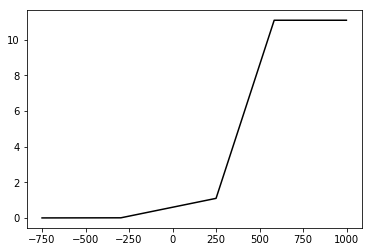

In [3]:
time = np.arange(-750, 1000)

new = new_vitesse(time, 1, -300, 2, 250, 10, 30, False)

plt.plot(time, new, 'k');

In [4]:
def new_fit(num_s) :
    
    
    sujets = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
    time_s = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
            '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
            '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']
    
    print(sujets[num_s])
    
    with open('data/enregistrement_%s_%s.pkl'%(sujets[num_s], time_s[num_s]), 'rb') as fichier :
        exp = pickle.load(fichier, encoding='latin1')
    
    A = ANEMO(exp)
    
    datafile = 'data/enregistrement_%s_%s.asc'%(sujets[num_s], time_s[num_s])
    data = read_edf(datafile, 'TRIALID')
    
    list_param_enre = ['start_anti', 'a_anti', 'latency', 'maxi', 'ramp_pursuit']
    param = {}
    for name in list_param_enre : param[name] = []

    for block in range(exp['N_blocks']) :
        for name in list_param_enre : param[name].append([])

        for trial in range(exp['N_trials']) :

            print('block, trial = ', block, trial)

            time_sup = 280

            trial_data = trial + exp['N_trials']*block
            arg = A.arg(data[trial_data], trial=trial, block=block)

            velocity_NAN = A.velocity_NAN(**arg, filt='velocity')

            data_trial = velocity_NAN[:-time_sup]
            trackertime = arg.trackertime[:-time_sup]

            max_latency = []
            for sac in range(len(arg.saccades)) :
                if (arg.saccades[sac][0]-arg.t_0) >= (arg.TargetOn-arg.t_0+100) :
                    max_latency.append((arg.saccades[sac][0]-arg.t_0))
            if max_latency == [] :
                max_latency.append(len(trackertime))
            max_latency = max_latency[0]

            value_latency, value_maxi, value_anti = A.classical_method.Full(data_trial, arg.TargetOn-arg.t_0)

            if np.isnan(value_latency): value_latency= arg.TargetOn-arg.t_0+100
            if np.isnan(value_anti): value_anti= 0.
            if np.isnan(value_maxi): value_maxi= 15.


            if value_latency >= max_latency-50 : value_latency = max_latency-150
            if value_latency > 250 :             value_latency = arg.TargetOn-arg.t_0+100

            param_fit=[{'name':'ramp_pursuit', 'value':100, 'min':40, 'max':800, 'vary':'vary'},
                       #{'name':'ramp_pursuit', 'value':40, 'min':40, 'max':80, 'vary':'vary'},
                       {'name':'maxi', 'value':value_maxi, 'min':5., 'max':40., 'vary':True},
                       {'name':'dir_target', 'value':arg.dir_target, 'min':None,
                        'max':None, 'vary':False },
                       {'name':'a_anti', 'value':value_anti, 'min':-40., 'max':40., 'vary':True  },
                       {'name':'latency', 'value':value_latency, 'min':arg.TargetOn-arg.t_0+75,
                        'max':max_latency, 'vary':True  },
                       {'name':'start_anti', 'value':arg.TargetOn-arg.t_0-100, 'min':arg.StimulusOf-arg.t_0-200,
                        'max':arg.TargetOn-arg.t_0+75, 'vary':'vary'}]

            inde_vars={'x':np.arange(len(trackertime))}

            equation = new_vitesse
            model = Model(equation, independent_vars=inde_vars.keys())

            vary = False
            params = Parameters()
            for num_par in range(len(param_fit)) :
                if param_fit[num_par]['vary'] == 'vary' : var = vary
                else :                                    var = param_fit[num_par]['vary']
                params.add(param_fit[num_par]['name'],
                           value=param_fit[num_par]['value'],
                           min=param_fit[num_par]['min'],
                           max=param_fit[num_par]['max'],
                           vary=var)

            params.add('do_whitening', value=False, vary=False)

            out = model.fit(data_trial, params, nan_policy='omit', **inde_vars)

            # make the other parameters vary now
            for num_par in range(len(param_fit)) :
                if param_fit[num_par]['vary'] == 'vary' :
                    out.params[param_fit[num_par]['name']].set(vary=True)

            f = model.fit(data_trial, out.params, method='nelder', nan_policy='omit', **inde_vars)

            #------------------------------------------------------------------------------------------------
            time = arg.trackertime[:-time_sup]-arg.TargetOn
            onset = arg.TargetOn - arg.t_0

            list_param = ['start_anti', 'a_anti', 'latency', 'ramp_pursuit', 'maxi']


            for name in list_param_enre :
                if name in f.values.keys() :
                    if name in ['start_anti', 'latency'] : val = f.values[name] - onset
                    else :                                 val = f.values[name]
                    param[name][block].append(val)
                    
    # saves the fit parameters
    with open('param_Fit_%s_fct_Vline_filt_30.pkl'%sujets[num_s], 'wb') as fichier:
        f = pickle.Pickler(fichier)
        f.dump(param)

In [ ]:
new_fit(1)